In [31]:
import os
import shutil
import uuid
import torch
import torch.nn as nn
from torchvision import transforms
from timm import create_model
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

In [32]:
# ⚠️ Manually update this path before running each dataset
DATASET_FOLDER = "../DF/unfiltered1"  # Change this for each dataset

# Define filtered dataset folder (Persistent across runs)
FILTERED_DATASET_FOLDER = "./output_dataset"

# Emotion categories based on the model (must match output folder)
EMOTION_CATEGORIES = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [33]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Load Model
MODEL_PATH = "adaptive_efficientnetv2_rw_s_emotion_model.pth"

def load_model(model_path, num_classes=8):
    print("🔄 Loading the trained EfficientNet-B2 model...")
    model = create_model('efficientnetv2_rw_s', pretrained=True, num_classes=num_classes, in_chans=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
    return model

✅ Using device: cuda


In [34]:
# Define image transformation (grayscale processing)
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load model
model = load_model(MODEL_PATH)

# Initialize confusion matrix tracking
actual_labels = []
predicted_labels = []

🔄 Loading the trained EfficientNet-B2 model...


C:\Users\Tuf\AppData\Local\Temp\ipykernel_2500\620158755.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devic

✅ Model loaded successfully!


In [35]:
# Step 1: Create the "Filtered_Dataset" folder with emotion subfolders
def initialize_filtered_dataset():
    if not os.path.exists(FILTERED_DATASET_FOLDER):
        os.makedirs(FILTERED_DATASET_FOLDER)

    for emotion in EMOTION_CATEGORIES:
        emotion_folder = os.path.join(FILTERED_DATASET_FOLDER, emotion)
        if not os.path.exists(emotion_folder):
            os.makedirs(emotion_folder)

In [36]:
# Step 2: Process each category separately (Only process folders that exist in output dataset)
def process_category(emotion_category):
    global actual_labels, predicted_labels

    # Define source folder for the category
    source_folder = os.path.join(DATASET_FOLDER, emotion_category)

    # Check if the source folder exists
    if not os.path.exists(source_folder):
        print(f"❌ Skipping {emotion_category}: No such folder in dataset.")
        return

    # Get all images in the category folder
    image_paths = [
        os.path.join(source_folder, file) for file in os.listdir(source_folder)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    print(f"📂 Processing {len(image_paths)} images in category: {emotion_category}")

    for img_path in tqdm(image_paths, desc=f"Processing {emotion_category}"):
        try:
            # Load image and apply transformations
            img = transforms.functional.to_pil_image(torch.zeros(1, 260, 260))  # Placeholder in case of error
            if os.path.exists(img_path):
                img = Image.open(img_path).convert("L")  # Convert to grayscale
            
            input_tensor = image_transform(img).unsqueeze(0).to(device)  # Add batch dimension

            # Predict emotion
            with torch.no_grad():
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
                predicted_emotion = EMOTION_CATEGORIES[predicted.item()]

            # Track results for confusion matrix
            actual_labels.append(emotion_category)
            predicted_labels.append(predicted_emotion)

            # If the prediction matches the current category, copy it to the filtered dataset
            if predicted_emotion == emotion_category:
                target_folder = os.path.join(FILTERED_DATASET_FOLDER, emotion_category)

                # Prevent duplicate filenames by appending a unique identifier
                unique_name = str(uuid.uuid4())[:8] + "_" + os.path.basename(img_path)
                target_path = os.path.join(target_folder, unique_name)

                # Copy image to the correct category
                shutil.copy(img_path, target_path)

        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")
            continue  # Skip the current image and proceed

In [37]:
# Step 3: Generate and display a confusion matrix
def generate_confusion_matrix():
    if len(actual_labels) == 0 or len(predicted_labels) == 0:
        print("❌ No images were processed. Skipping confusion matrix.")
        return

    # Compute confusion matrix
    cm = confusion_matrix(actual_labels, predicted_labels, labels=EMOTION_CATEGORIES)

    # Convert to DataFrame for better readability
    cm_df = pd.DataFrame(cm, index=EMOTION_CATEGORIES, columns=EMOTION_CATEGORIES)

    # Display the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predicted Emotion")
    plt.ylabel("Actual Emotion")
    plt.title("Emotion Classification Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Show the plot
    plt.show()

📂 Processing 5500 images in category: Anger


Processing Anger: 100%|██████████| 5500/5500 [06:41<00:00, 13.71it/s]


❌ Skipping Contempt: No such folder in dataset.
📂 Processing 4303 images in category: Disgust


Processing Disgust: 100%|██████████| 4303/4303 [05:00<00:00, 14.31it/s]


📂 Processing 5500 images in category: Fear


Processing Fear: 100%|██████████| 5500/5500 [06:31<00:00, 14.06it/s]


📂 Processing 5500 images in category: Happy


Processing Happy: 100%|██████████| 5500/5500 [06:35<00:00, 13.90it/s]


📂 Processing 9750 images in category: Neutral


Processing Neutral: 100%|██████████| 9750/9750 [12:19<00:00, 13.19it/s]


📂 Processing 500 images in category: Sad


Processing Sad: 100%|██████████| 500/500 [00:38<00:00, 13.09it/s]


📂 Processing 5500 images in category: Surprise


Processing Surprise: 100%|██████████| 5500/5500 [07:01<00:00, 13.04it/s]


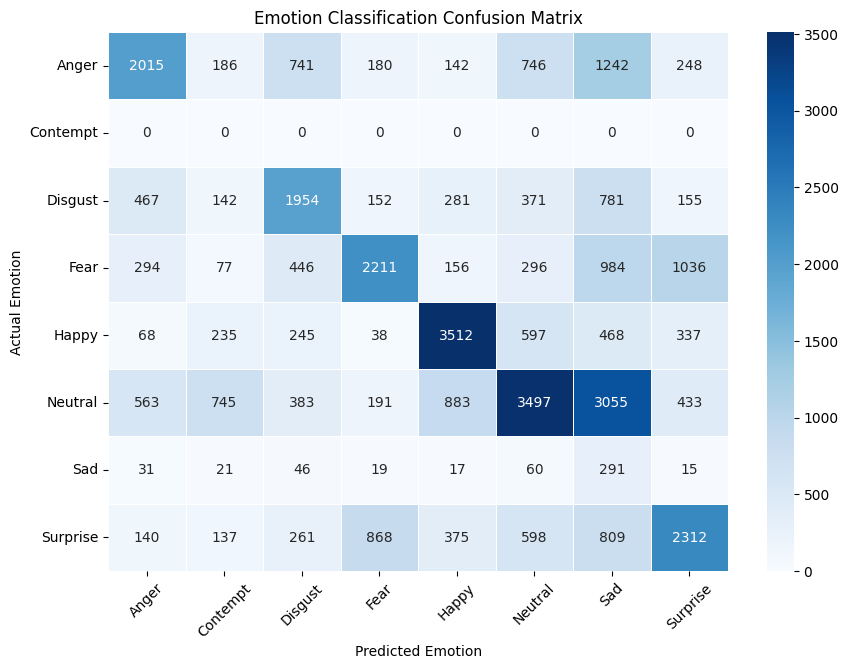

✅ Processing completed for dataset: ../DF/unfiltered1
🔄 You can now update DATASET_FOLDER to the next dataset and rerun the script.


In [38]:
# Run the script
if __name__ == "__main__":
    initialize_filtered_dataset()

    # Process only classes that exist in the output folder
    existing_classes = [folder for folder in EMOTION_CATEGORIES if os.path.exists(os.path.join(FILTERED_DATASET_FOLDER, folder))]
    
    for category in existing_classes:
        process_category(category)

    # Generate and display confusion matrix
    generate_confusion_matrix()

    print(f"✅ Processing completed for dataset: {DATASET_FOLDER}")
    print("🔄 You can now update DATASET_FOLDER to the next dataset and rerun the script.")